In [6]:
import numpy as np
from sklearn.svm import SVC

import torch
from torch.utils.data import DataLoader

from datasets.data import *

parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--rank', type=int, default=-1, help='the rank for current GPU or process, '
                    'ususally one process per GPU')
parser.add_argument('--k', type=int, default=15, metavar='N',
                        help='Num of nearest neighbors to use')
parser.add_argument('--dropout', type=float, default=0.5,
                        help='dropout rate')
args = parser.parse_args("")

In [19]:
args.rank = 0

pretrained_path = 'checkpoints/crosspoint_dgcnn_cls3/models/best_model.pth'
device = torch.device("cuda:%d" % args.rank)
pretrained_model = torch.load(pretrained_path)
# pretrained_model are saved in DDP mode, but we test on a single GPU, 
# therefore, it is neccessary to do the following step to make key matched
# https://discuss.pytorch.org/t/missing-keys-unexpected-keys-in-state-dict-when-loading-self-trained-model/22379
pretrained_model = {key.replace("module.", ""): value for key, value in pretrained_model.items()}

model_self = DGCNN(args).to(device)
model_self.load_state_dict(
    pretrained_model
)

<All keys matched successfully>

In [20]:
for name, module in model_self.named_modules():
    print(name, module)

 DGCNN(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [21]:
# seg_num_all = 50
# model = DGCNN_partseg(args, seg_num_all, pretrain=False).to(device)
# model.load_state_dict(
#     torch.load('checkpoints/crosspoint_dgcnn_seg2/models/best_model.pth'),
#     strict=False
# )

# ModelNet40

In [36]:
train_loader_1 = DataLoader(ModelNet40SVM(partition='train', num_points=args.num_points),
                              batch_size=128, shuffle=True)
test_loader_1 = DataLoader(ModelNet40SVM(partition='test', num_points=args.num_points),
                              batch_size=128, shuffle=True)
print('Done !!')

Done !!


# ScanObjectNN

In [37]:
train_loader_2 = DataLoader(ScanObjectNNSVM(partition='train', num_points=args.num_points),
                              batch_size=64, shuffle=True)
test_loader_2 = DataLoader(ScanObjectNNSVM(partition='test', num_points=args.num_points),
                              batch_size=64, shuffle=True)
print('Done !!')

Done !!


# Load ModelNet Train Feats

In [38]:
import random

feats_train_1 = []
labels_train_1 = []
model = model_self.to(device)
model = model.eval()

dataset = "ModelNet40" # Choose Dataset ["ModelNet40, ScanObjectNN"]

for i, (data, label) in enumerate(train_loader_1):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[1]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_train_1.append(feat)
    labels_train_1 += labels

feats_train_1 = np.array(feats_train_1)
labels_train_1 = np.array(labels_train_1)
print(feats_train_1.shape)
print(labels_train_1.shape)

(9840, 2048)
(9840,)


# Load ScanOjbectNN Train Feats

In [39]:
import random

feats_train_2 = []
labels_train_2 = []
model = model_self.to(device)
model = model.eval()

dataset = "ScanObjectNN" # Choose Dataset ["ModelNet40, ScanObjectNN"]

for i, (data, label) in enumerate(train_loader_2):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[1]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_train_2.append(feat)
    labels_train_2 += labels

feats_train_2 = np.array(feats_train_2)
labels_train_2 = np.array(labels_train_2)
print(feats_train_2.shape)
print(labels_train_2.shape)

(2309, 2048)
(2309,)


# Load ModelNet Test Feats

In [40]:
import random

feats_test_1 = []
labels_test_1 = []
model = model_self.to(device)
model = model.eval()

for i, (data, label) in enumerate(test_loader_1):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[1]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_test_1.append(feat)
    labels_test_1 += labels

feats_test_1 = np.array(feats_test_1)
labels_test_1 = np.array(labels_test_1)
print(feats_test_1.shape)
print(labels_test_1.shape)

(2468, 2048)
(2468, 1)


# Load ScanObjectNN Test Feats

In [41]:
import random

feats_test_2 = []
labels_test_2 = []
model = model_self.to(device)
model = model.eval()

for i, (data, label) in enumerate(test_loader_2):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[1]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_test_2.append(feat)
    labels_test_2 += labels

feats_test_2 = np.array(feats_test_2)
labels_test_2 = np.array(labels_test_2)
print(feats_test_2.shape)
print(labels_test_2.shape)

(581, 2048)
(581,)


# Train Linear Model on ModelNet

In [48]:
# Linear SVM regularization parameter C, can be tuned
# The strength of the regularization is inversely proportional to C
c = 10
model_tl_1 = SVC(C = c, kernel ='linear')
model_tl_1.fit(feats_train_1, labels_train_1)
print(f"C = {c} : {model_tl_1.score(feats_test_1, labels_test_1)}")

C = 10 : 0.8865478119935171


# Train Linear Model on ScanObjectNN

In [47]:
# Linear SVM regularization parameter C, can be tuned
# The strength of the regularization is inversely proportional to C
c = 100
model_tl_2 = SVC(C = c, kernel ='linear')
model_tl_2.fit(feats_train_2, labels_train_2)
print(f"C = {c} : {model_tl_2.score(feats_test_2, labels_test_2)}")

C = 100 : 0.7418244406196214


In [ ]:
# Results:
# ModelNet40   -> C = 10000 : 0.8731766612641815
    # C = 0.01 : 0.8861426256077796
    # C = 0.1 : 0.8942463533225283
    # C = 1 : 0.8869529983792545
    # C = 10 : 0.8865478119935171
    # C = 100 : 0.8865478119935171
# ScanOjbectNN -> C = 10000 : 0.648881239242685
    # C = 100 : 0.7418244406196214
    # C = 10 : 0.7418244406196214
    # C = 1 : 0.7418244406196214
    # C = 0.1 : 0.7573149741824441
    # C = 0.01 : 0.7314974182444062

### t-SNE visualization

In [15]:
import torch as t
from sklearn.manifold import TSNE

X = t.randn(1024, 256).numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

In [16]:
X_embedded.shape

(1024, 2)

[Text(0.5, 1.0, 'Random data T-SNE projection')]

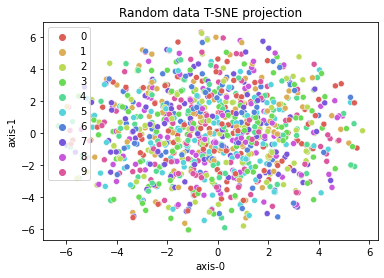

In [20]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame()
# "y" represents the number of samples
df["y"] = t.randint(0, 10, (1024,)).numpy()
df["axis-0"] = X_embedded[:,0]
df["axis-1"] = X_embedded[:,1]

sns.scatterplot(x="axis-0", y="axis-1", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Random data T-SNE projection")